# Putting it all togather

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations

from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, scale, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.ensemble import RandomForestClassifier

pd.options.mode.chained_assignment = None


In [2]:
def load_prepared_data():
    df_train = pd.read_csv('./data/output/processed_train.csv', header=0)
    df_test = pd.read_csv('./data/output/processed_test.csv', header=0)
    features = list(set(df_train.columns) - {'Vote'})
    target = 'Vote'

    df_train_X = df_train[features]
    df_train_Y = df_train[target]
    df_test_X = df_test[features]
    df_test_Y = df_test[target]
    # labels = {"0":"Blues","1":"Browns","2":"Greens","3":"Greys","4":"Oranges","5":"Pinks","6":"Purples","7":"Reds","8":"Whites","9":"Yellows" }
    labels = ["Blues", "Browns", "Greens", "Greys", "Oranges", "Pinks", "Purples", "Reds", "Whites", "Yellows"]
    return df_train_X, df_train_Y, df_test_X, df_test_Y, labels

In [3]:
df_train_X, df_train_Y, df_test_X, df_test_Y, labels = load_prepared_data()
df_train_Y_nums = df_train_Y
df_test_Y_nums = df_test_Y
df_train_Y = df_train_Y.map(lambda x: labels[int(x)])
df_test_Y = df_test_Y.map(lambda x: labels[int(x)])

train_val_data = pd.concat([df_train_X])
features = train_val_data.values
labels = pd.concat([df_train_Y]).values

# Loading the new data

In [4]:
df_new = pd.read_csv('./data/ElectionsData_Pred_Features.csv', header=0)

### Looking at the data
checing for nil values

In [5]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 38 columns):
IdentityCard_Num                                 10000 non-null int64
Occupation_Satisfaction                          9944 non-null float64
Avg_monthly_expense_when_under_age_21            9935 non-null float64
AVG_lottary_expanses                             9951 non-null float64
Most_Important_Issue                             9964 non-null object
Avg_Satisfaction_with_previous_vote              9930 non-null float64
Looking_at_poles_results                         9972 non-null object
Garden_sqr_meter_per_person_in_residancy_area    9941 non-null float64
Married                                          9970 non-null object
Gender                                           9974 non-null object
Voting_Time                                      9973 non-null object
Financial_balance_score_.0.1.                    9938 non-null float64
X.Of_Household_Income                         

In [6]:
df_new.describe()

,IdentityCard_Num,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Avg_Satisfaction_with_previous_vote,Garden_sqr_meter_per_person_in_residancy_area,Financial_balance_score_.0.1.,X.Of_Household_Income,Avg_government_satisfaction,Avg_education_importance,...,Avg_size_per_room,Weighted_education_rank,X._satisfaction_financial_policy,Avg_monthly_income_all_years,Last_school_grades,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Overall_happiness_score,Num_of_kids_born_last_10_years
count,10000.00000,9944.000000,9935.000000,9951.000000,9930.000000,9941.000000,9938.000000,9942.000000,9936.000000,9934.000000,...,9937.000000,9936.000000,9932.000000,9936.000000,9925.000000,9934.000000,9943.000000,9929.000000,9937.000000,9925.000000
mean,5000.50000,5.531376,505.998923,68755.239663,168.550741,412.560822,0.498689,0.499769,4.980705,5.016348,...,20.692249,205.153477,49.966199,49580.231521,72.837280,2.001007,671.019263,9.660288,474.314407,0.664282
std,2886.89568,2.864049,432.341238,70172.943560,144.040190,135.629175,0.289392,0.287132,2.886140,2.883037,...,2.850650,109.418043,29.008778,85147.494780,20.308241,1.253927,126.447079,2.757766,108.879774,1.047991
min,1.00000,1.000000,-760.581980,-153663.209748,-253.527327,0.935073,0.000297,0.000056,0.000214,0.000159,...,1.242612,5.855398,0.004262,9.751126,30.000000,0.000000,49.850510,5.000000,0.174146,0.000000
25%,2500.75000,3.000000,198.987026,25323.714338,66.288574,316.627960,0.247393,0.250963,2.445209,2.549850,...,19.478478,126.969613,24.852723,4622.859358,60.000000,1.000000,596.080915,8.000000,413.332738,0.000000
50%,5000.50000,6.000000,385.874725,49128.853934,128.606860,397.211181,0.497605,0.500869,5.015930,5.052688,...,20.666700,202.050611,49.587589,16832.901706,70.000000,2.000000,663.039829,9.000000,472.642204,0.000000
75%,7500.25000,8.000000,694.844597,87737.778185,231.159661,485.704871,0.748513,0.746006,7.483365,7.495372,...,22.045722,257.734904,75.381370,54058.397064,90.000000,3.000000,731.554884,12.000000,530.001654,1.000000
max,10000.00000,10.000000,2297.295696,568994.981131,765.765232,826.628682,0.999697,0.999984,9.997253,9.999821,...,26.984359,805.916767,99.996539,587172.155862,100.000000,7.000000,1069.941023,16.000000,772.526144,10.000000


In [7]:
df_validation = pd.read_csv('./data/output/raw_validation.csv', header=0)


In [8]:
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 38 columns):
Vote                                             2000 non-null object
Occupation_Satisfaction                          1959 non-null float64
Avg_monthly_expense_when_under_age_21            1954 non-null float64
AVG_lottary_expanses                             1956 non-null float64
Most_Important_Issue                             1986 non-null object
Avg_Satisfaction_with_previous_vote              1966 non-null float64
Looking_at_poles_results                         1982 non-null object
Garden_sqr_meter_per_person_in_residancy_area    1951 non-null float64
Married                                          1993 non-null object
Gender                                           1982 non-null object
Voting_Time                                      1983 non-null object
Financial_balance_score_(0-1)                    1967 non-null float64
%Of_Household_Income                           

__During this exersice we will try to treat the new data and the validation data the same
Meaning we will do the same operations on both, and than measure our success with the validation data.__

In [9]:
a = set(df_new.columns)
b = set(df_validation.columns)

print "Only in df_new"
print "_" * 40
for f in sorted(a-b):
    print f

print "Only in df_validation"
print "_" * 40
for f in sorted(b-a):
    print f

Only in df_new
________________________________________
Financial_balance_score_.0.1.
IdentityCard_Num
X.Of_Household_Income
X.Time_invested_in_work
X._satisfaction_financial_policy
Only in df_validation
________________________________________
%Of_Household_Income
%Time_invested_in_work
%_satisfaction_financial_policy
Financial_balance_score_(0-1)
Vote


#### Looks like we have broken columns between validation and new data. lets fix that:


In [10]:
df_new["%Of_Household_Income"] = df_new["X.Of_Household_Income"]
df_new["%Time_invested_in_work"] = df_new["X.Time_invested_in_work"]
df_new["%_satisfaction_financial_policy"] = df_new["X._satisfaction_financial_policy"]
df_new["Financial_balance_score_(0-1)"] = df_new["Financial_balance_score_.0.1."]

df_new.drop(['X.Of_Household_Income', 'X.Time_invested_in_work', 'X._satisfaction_financial_policy', 'Financial_balance_score_.0.1.'],inplace=True, axis=1)


## Preprocessing the new data and the Validation set

first, we want to "hide" unwanted colums from each dataset: 
- df_validation - has the "Vote" column 
- df_new - has the "IdentityCard_Num" column.

we will remove those for the data cleansing process, and glue them back after we're done.

In [11]:
validation_labels = df_validation['Vote']
new_data_IDs = df_new['IdentityCard_Num']

df_validation = df_validation.drop(['Vote'],axis=1)
df_new = df_new.drop(['IdentityCard_Num'],axis=1)

In [12]:
def rows_with_nan(_df):
    return Counter(_df.isnull().sum(axis=1).tolist())

def plot_rows_with_nan(_df, name=""):
    counter = rows_with_nan(_df)
    labels, histogram = zip(*counter.most_common())
    fig1, ax1 = plt.subplots()
    ax1.pie(histogram, labels=labels,
            colors = ['green', 'yellowgreen', 'yellow','orange', 'red'],
            autopct = lambda(p): '{:.0f}  ({:.2f}%)'.format(p * sum(histogram) / 100, p))
    ax1.axis('equal')
    plt.title(name)
    plt.show()
    

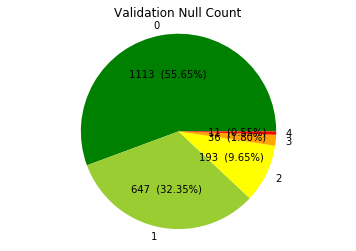

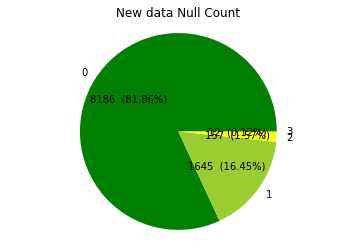

In [13]:
plot_rows_with_nan(df_validation, "Validation Null Count")
plot_rows_with_nan(df_new, "New data Null Count")


We can see that the new data has a lot less missing values than the validation data.
This is good, this means that for we are good on the validation data, we will be even better on the new data.

In [14]:
def group_features(_df):
    _df = _df.dropna()
    all_features = _df.columns
    categorical_features = _df.select_dtypes(include=["object"])
    numeric_features = _df.select_dtypes(exclude=["object"])

    return [all_features, categorical_features.columns, numeric_features.columns]



In [15]:
all_features, categorical_features, numeric_features = group_features(df_new)


#### Categorial Features

In [16]:
for f in categorical_features:
    print f

Most_Important_Issue
Looking_at_poles_results
Married
Gender
Voting_Time
Will_vote_only_large_party
Age_group
Main_transportation
Occupation
Financial_agenda_matters


#### Numeric Features

In [17]:
for f in numeric_features:
    print f

Occupation_Satisfaction
Avg_monthly_expense_when_under_age_21
AVG_lottary_expanses
Avg_Satisfaction_with_previous_vote
Garden_sqr_meter_per_person_in_residancy_area
Avg_government_satisfaction
Avg_education_importance
Avg_environmental_importance
Avg_Residancy_Altitude
Yearly_ExpensesK
Yearly_IncomeK
Avg_monthly_expense_on_pets_or_plants
Avg_monthly_household_cost
Phone_minutes_10_years
Avg_size_per_room
Weighted_education_rank
Avg_monthly_income_all_years
Last_school_grades
Number_of_differnt_parties_voted_for
Political_interest_Total_Score
Number_of_valued_Kneset_members
Overall_happiness_score
Num_of_kids_born_last_10_years
%Of_Household_Income
%Time_invested_in_work
%_satisfaction_financial_policy
Financial_balance_score_(0-1)


## Helper methods - taken from ex2 - Data cleansing
we will document them once we use them.

In [18]:

def fill_numeric_features(_df, features):
    for f in features:
        _df[f + "_fill"].fillna(_df[f + "_fill"].median(), inplace=True)


def fill_numeric_by_correlation(_df, factor, features):
    redundant_features = []
    cor = _df[features].dropna().corr()
    print "We choose " + str(factor) + " correlation as correlated"
    indices = np.where(cor > factor)
    indices = [(cor.index[x], cor.columns[y], cor.loc[cor.index[x],cor.columns[y]]) for x, y in zip(*indices) if  x < y]
    indices = sorted(indices, key=lambda pair: pair[2], reverse=True)
    for pair in indices:
        fill_f1_with_f2(_df, pair[0], pair[1], pair[2])
        redundant_features.append(pair[1])
    return redundant_features


def fill_f1_with_f2(_df, f1, f2, val):
    ratio = _df[f1].mean() / _df[f2].mean()
    print 'Filling ' + f1 + ' with ' + f2 + ' due to correlation of %f'% val
    for index, row in _df[_df[f1 + "_fill"].isnull()].iterrows():
        if ~np.isnan(_df[f2][index]):
            _df[f1 + "_fill"][index] = _df[f2][index] * ratio
    
    ratio = _df[f2].mean() / _df[f1].mean()
    print 'Filling ' + f2 + ' with ' + f1 + ' due to correlation %f'% val
    for index, row in _df[_df[f2 + "_fill"].isnull()].iterrows():
        if ~np.isnan(_df[f1][index]):
            _df[f2 + "_fill"][index] = _df[f1][index] * ratio

def remove_fill(_df, features):
    for f in features:
        _df[f] = _df[f + "_fill"]
        del _df[f + "_fill"]

def create_fill(_df, features):
    for f in features:
        _df[f + "_fill"] = _df[f]


In ex2 we showed that Most_Important_Issue is a mupltiplication of Last_school_grades.
lets fill with this info the missing values

In [19]:
most_important_issue_dic = {
    'Military' : 30.0,
    'Healthcare' : 80.0,
    'Environment' : 90.0,
    'Financial' : 60.0,
    'Education': 100.0,
    'Foreign_Affairs': 40.0,
    'Social':70.0,
    'Other': 50.0
}

def fill_most_important_issue_and_grades(_df ,most_important_issue_dic):
    for k, v in most_important_issue_dic.iteritems():
        ks = _df[_df['Most_Important_Issue'] == k]
        ks['Last_school_grades'].fillna(v,inplace=True)
        
        vs = _df[_df['Last_school_grades'] == v]
        vs['Most_Important_Issue'].fillna(k, inplace=True)
    
        
fill_most_important_issue_and_grades(df_new, most_important_issue_dic)
fill_most_important_issue_and_grades(df_validation, most_important_issue_dic)


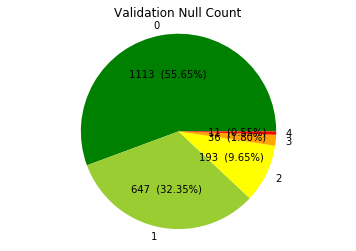

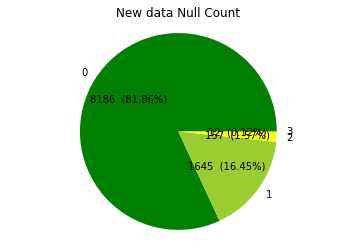

In [20]:
plot_rows_with_nan(df_validation, "Validation Null Count")
plot_rows_with_nan(df_new, "New data Null Count")

We have seen in Ex02 that Looking_at_poles_results is a binary of Will_vote_only_large_party

lets fill the data with this info

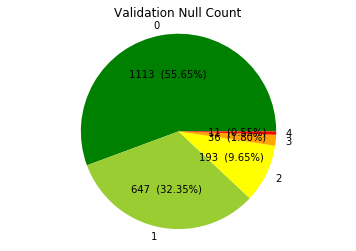

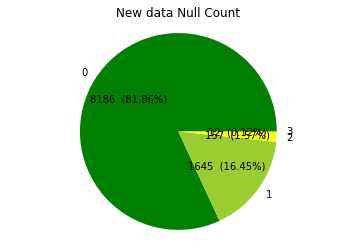

In [21]:
plot_rows_with_nan(df_validation, "Validation Null Count")
plot_rows_with_nan(df_new, "New data Null Count")

First we create a 'fill' column for each numric feature
this column will use us as the temp fillet for the features to prevent wrong data fill due to filling order

In [22]:
create_fill(df_validation, numeric_features)
create_fill(df_new, numeric_features)


### Using Pearson's Correlation Coefficient

At this stage we are looking for corrlation between features
We've set a threshold of 0.7 for the pearson's correlation coefficient. 
Any two features with a value of that and above will be considered "highly correlated" and will be used to to fill the data by multiplying the value from one column by that ratio and set it to the other.

Since most of the columns are either complete or have at most 1 missing value, this will be a very useful tool.

Our method will start from the most corrlated features till it gets to 0.7.

In [23]:
corr_factor = 0.7
print "**" * 40
print "VALIDATION"
print "**" * 40
fill_numeric_by_correlation(df_validation, corr_factor, numeric_features)

print "**" * 40
print "NEW DATA"
print "**" * 40
fill_numeric_by_correlation(df_new, corr_factor, numeric_features)

********************************************************************************
VALIDATION
********************************************************************************
We choose 0.7 correlation as correlated
Filling Avg_monthly_expense_when_under_age_21 with Avg_Satisfaction_with_previous_vote due to correlation of 1.000000
Filling Avg_Satisfaction_with_previous_vote with Avg_monthly_expense_when_under_age_21 due to correlation 1.000000
Filling Garden_sqr_meter_per_person_in_residancy_area with Avg_monthly_expense_on_pets_or_plants due to correlation of 0.989973
Filling Avg_monthly_expense_on_pets_or_plants with Garden_sqr_meter_per_person_in_residancy_area due to correlation 0.989973
Filling Yearly_IncomeK with Avg_size_per_room due to correlation of 0.979277
Filling Avg_size_per_room with Yearly_IncomeK due to correlation 0.979277
Filling Garden_sqr_meter_per_person_in_residancy_area with Phone_minutes_10_years due to correlation of 0.974430
Filling Phone_minutes_10_years with G

['Avg_Satisfaction_with_previous_vote',
 'Avg_monthly_expense_on_pets_or_plants',
 'Avg_size_per_room',
 'Phone_minutes_10_years',
 'Phone_minutes_10_years',
 'Political_interest_Total_Score',
 'Avg_monthly_household_cost',
 'Avg_size_per_room',
 'Avg_monthly_income_all_years',
 'Avg_monthly_income_all_years',
 'Political_interest_Total_Score',
 'Political_interest_Total_Score',
 'AVG_lottary_expanses',
 'Avg_Satisfaction_with_previous_vote',
 'Avg_monthly_income_all_years']

In [24]:
remove_fill(df_validation, numeric_features)
remove_fill(df_new, numeric_features)

### Lets check the missing values status now
looks like we made an improvment, but there is still a way to go.

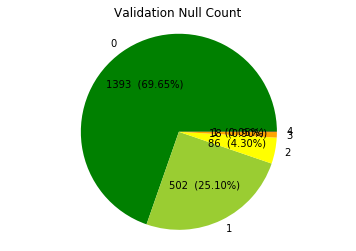

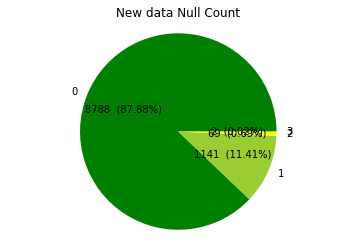

In [25]:
plot_rows_with_nan(df_validation, "Validation Null Count")
plot_rows_with_nan(df_new, "New data Null Count")

In [26]:
def train_on_feature(df, feature):
    train_data_X = df.drop([feature], axis=1).values
    train_data_Y = df[feature].values
    clf = RandomForestRegressor(n_estimators=50)
      
    return clf.fit(train_data_X, train_data_Y)

def build_clf(df, feature):
    df_tmp = df.copy()
    df_tmp_noNaN = df_tmp.dropna()
    print feature
    print len(df_tmp[pd.isnull(df_tmp[feature])])
    to_predict = df_tmp[pd.isnull(df_tmp[feature])].drop([feature],axis=1)
    clf = train_on_feature(df_tmp_noNaN, feature)
    return to_predict, clf


def fill_numerical(_df, numeric_features):
    results = {}
    df_numeric= _df[numeric_features]
    
    indeces_with_less_than_2_nan = [df_numeric.loc[k].isnull().sum() < 2 for k in df_numeric.index.values]
    df_for_prediction = df_numeric.loc[indeces_with_less_than_2_nan]
    
    for feature in numeric_features:
        to_predict, clf = build_clf(df_for_prediction, feature) 
        if to_predict.shape[0] > 0:           
            results[feature] = zip(to_predict.index.values, clf.predict(to_predict))
    
    #fill in the missing values
    for feature, res in results.iteritems():
        for item in res:
            _df[feature][item[0]] = item[1]
    return _df

In [27]:
# fill_numerical(df_validation, numeric_features)
# fill_numerical(df_new, numeric_features)

1

1

### Looks like we are getting closer
now all the numeric fields are full.

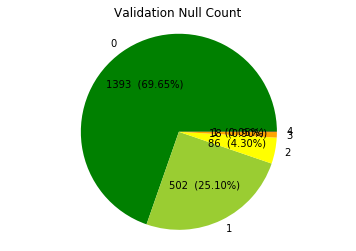

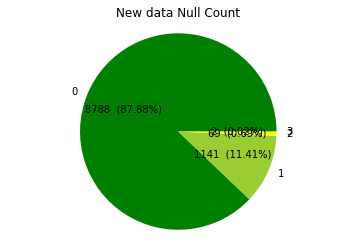

In [28]:
plot_rows_with_nan(df_validation, "Validation Null Count")
plot_rows_with_nan(df_new, "New data Null Count")

In [29]:
# from fancyimpute import SoftImpute

# def complete_fancy_impute(_df, features):
#     data_no_cat = _df.drop(categorical_features, axis=1)
#     completed = SoftImpute().complete(data_no_cat)
#     print completed
# #     _df[data_no_cat.columns] = completed
#     plot_pie_nan_per_row(df)

# complete_fancy_impute(df_validation)

### Lets go for categorial now

In [30]:
# def transform_bool(_df, name):
#     _df[name] = _df[name].map({'No': -1, "Maybe": 0, 'Yes': 1}).astype(int)


# def transform_category(_df, name):
#     for cat in _df[name].unique():
#         _df["Is_" + name + "_" + cat] = (_df[name] == cat).astype(int)
#     del _df[name]

# def transform_manual(_df):
#     _df["Age_group"] = _df["Age_group"].map({'Below_30': 0, '30-45': 1, '45_and_up': 2}).astype(int)
#     _df["Voting_Time"] = _df["Voting_Time"].map({'By_16:00': 0, 'After_16:00': 1}).astype(int)
#     _df["Gender"] = _df["Gender"].map({'Male': -1, 'Female': 1}).astype(int)

#     transform_bool(_df, "Looking_at_poles_results")
#     transform_bool(_df, "Married")
#     transform_bool(_df, "Financial_agenda_matters")
#     transform_bool(_df, "Will_vote_only_large_party")
#     transform_category(_df, "Most_Important_Issue")
#     transform_category(_df, "Occupation")
#     transform_category(_df, "Main_transportation")

# def transform_for_predicrtion(_df):
#     _df["Age_group"] = _df["Age_group"].map({'Below_30': 0, '30-45': 1, '45_and_up': 2}).astype(int)
#     _df["Voting_Time"] = _df["Voting_Time"].map({'By_16:00': 0, 'After_16:00': 1}).astype(int)
#     _df["Gender"] = _df["Gender"].map({'Male': -1, 'Female': 1}).astype(int)

#     transform_bool(_df, "Looking_at_poles_results")
#     transform_bool(_df, "Married")
#     transform_bool(_df, "Financial_agenda_matters")
#     transform_bool(_df, "Will_vote_only_large_party")

# def drop_if_exists(_df, column):
#     if column in _df.columns:
#         _df.drop([column], inplace=True, axis=1)
    
# def train_on_feature_cat(df, feature):
#     df_transformed = df.copy()
#     transform_for_predicrtion(df_transformed)
    
#     train_data_Y = df_transformed[feature].values
#     drop_if_exists(df_transformed, "Most_Important_Issue")
#     drop_if_exists(df_transformed, "Occupation")
#     drop_if_exists(df_transformed, "Main_transportation")
#     drop_if_exists(df_transformed, feature)

#     print df_transformed.info()
#     train_data_X = df_transformed.values
#     print train_data_Y

#     clf = RandomForestClassifier(n_estimators=50)
#     return clf.fit(train_data_X, train_data_Y)

# def build_clf_cat(df, feature):
#     df_tmp = df.copy()
#     df_tmp_noNaN = df_tmp.dropna()
    
#     to_predict = df_tmp[pd.isnull(df_tmp[feature])].drop([feature],axis=1)
    
#     to_predic_transformed = transform_for_predicrtion(df_tmp)
#     drop_if_exists(to_predic_transformed, "Most_Important_Issue")
#     drop_if_exists(to_predic_transformed, "Occupation")
#     drop_if_exists(to_predic_transformed, "Main_transportation")
    
    
#     clf = train_on_feature_cat(df_tmp_noNaN, feature)
#     return to_predic_transformed, clf


# def fill_cat(_df, categorial_features):
#     results = {}
    
#     indeces_with_less_than_2_nan = [_df.loc[k].isnull().sum() < 2 for k in _df.index.values]
#     df_for_prediction = _df.loc[indeces_with_less_than_2_nan]
    
#     for feature in categorial_features:
#         print feature
#         to_predict, clf = build_clf_cat(df_for_prediction, feature) 
#         if to_predict.shape[0] > 0:           
#             results[feature] = zip(to_predict.index.values, clf.predict(to_predict))
    
#     #fill in the missing values
#     for feature, res in results.iteritems():
#         for item in res:
#             _df[feature][item[0]] = item[1]
#     return _df

In [31]:
def fill_cat_simple(df, categorical_features):
    for f in categorical_features:
        df[f].fillna(Counter(df[f].dropna()).most_common(1)[0][0], inplace=True)

def fill_numeric_simple(df, numeric_features):
    for f in numeric_features:
        df[f].fillna(df[f].mean(), inplace=True)

def fill_cat_simple(df, categorical_features):
    for f in categorical_features:
        df[f].fillna(Counter(df[f].dropna()).most_common(1)[0][0], inplace=True)
fill_cat_simple(df_validation, categorical_features)


In [32]:
fill_cat_simple(df_validation, categorical_features)
fill_numeric_simple(df_validation, numeric_features)

fill_cat_simple(df_new, categorical_features)
fill_numeric_simple(df_new, numeric_features)

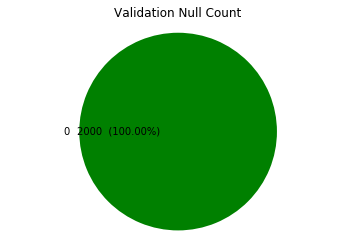

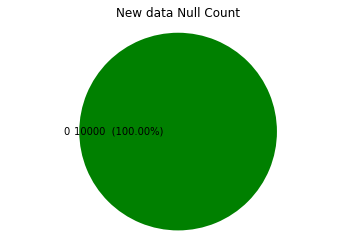

In [33]:
plot_rows_with_nan(df_validation, "Validation Null Count")
plot_rows_with_nan(df_new, "New data Null Count")

# Looks like we are done with data imputation
### Now we can transform and scale the data
#### Lets look what we have

In [34]:
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 37 columns):
Occupation_Satisfaction                          2000 non-null float64
Avg_monthly_expense_when_under_age_21            2000 non-null float64
AVG_lottary_expanses                             2000 non-null float64
Most_Important_Issue                             2000 non-null object
Avg_Satisfaction_with_previous_vote              2000 non-null float64
Looking_at_poles_results                         2000 non-null object
Garden_sqr_meter_per_person_in_residancy_area    2000 non-null float64
Married                                          2000 non-null object
Gender                                           2000 non-null object
Voting_Time                                      2000 non-null object
Financial_balance_score_(0-1)                    2000 non-null float64
%Of_Household_Income                             2000 non-null float64
Avg_government_satisfaction                   

#### Now lets transform the categorial features to numric values

In [35]:
def transform_bool(_df, name):
    _df[name] = _df[name].map({'No': -1, "Maybe": 0, 'Yes': 1}).astype(int)


def transform_category(_df, name):
    for cat in _df[name].unique():
        _df["Is_" + name + "_" + cat] = (_df[name] == cat).astype(int)
    del _df[name]


def transform_manual(_df):
    _df["Age_group"] = _df["Age_group"].map({'Below_30': 0, '30-45': 1, '45_and_up': 2}).astype(int)
    _df["Voting_Time"] = _df["Voting_Time"].map({'By_16:00': 0, 'After_16:00': 1}).astype(int)
    _df["Gender"] = _df["Gender"].map({'Male': -1, 'Female': 1}).astype(int)

    transform_bool(_df, "Looking_at_poles_results")
    transform_bool(_df, "Married")
    transform_bool(_df, "Financial_agenda_matters")
    transform_bool(_df, "Will_vote_only_large_party")
    transform_category(_df, "Most_Important_Issue")
    transform_category(_df, "Occupation")
    transform_category(_df, "Main_transportation")
    
transform_manual(df_validation)
transform_manual(df_new)
                 

#### Now lets scale all the numeric features

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

# df_new.describe()
def scale_numeric(_df, features):
    for f in features:
        _df[f] = (_df[f] - _df[f].min()) / (_df[f].max() - _df[f].min())
        
scale_numeric(df_validation, numeric_features)
scale_numeric(df_new, numeric_features)



In [37]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 51 columns):
Occupation_Satisfaction                          10000 non-null float64
Avg_monthly_expense_when_under_age_21            10000 non-null float64
AVG_lottary_expanses                             10000 non-null float64
Avg_Satisfaction_with_previous_vote              10000 non-null float64
Looking_at_poles_results                         10000 non-null int64
Garden_sqr_meter_per_person_in_residancy_area    10000 non-null float64
Married                                          10000 non-null int64
Gender                                           10000 non-null int64
Voting_Time                                      10000 non-null int64
Avg_government_satisfaction                      10000 non-null float64
Avg_education_importance                         10000 non-null float64
Avg_environmental_importance                     10000 non-null float64
Avg_Residancy_Altitude              

In [38]:
fixes_useful_features = [ #fixed
    'Avg_Satisfaction_with_previous_vote',
    'Number_of_valued_Kneset_members',
    'Yearly_IncomeK',
    'Overall_happiness_score',
    'Avg_monthly_expense_when_under_age_21',
    'Will_vote_only_large_party',
    'Garden_sqr_meter_per_person_in_residancy_area',
    'Is_Most_Important_Issue_Other',
    'Is_Most_Important_Issue_Financial',
    'Is_Most_Important_Issue_Environment',
    'Is_Most_Important_Issue_Military',
    'Is_Most_Important_Issue_Education',
    'Is_Most_Important_Issue_Foreign_Affairs',
    'Is_Most_Important_Issue_Social',
    'Weighted_education_rank'
]

fixes_useful_features = [
    'Avg_Satisfaction_with_previous_vote',
    'Number_of_valued_Kneset_members',
    'Yearly_IncomeK',
    'Overall_happiness_score',
    'Avg_monthly_expense_when_under_age_21',
    'Will_vote_only_large_party',
    'Garden_sqr_meter_per_person_in_residancy_area',
    'Is_Most_Important_Issue_Other',
    'Is_Most_Important_Issue_Financial',
    'Is_Most_Important_Issue_Environment',
    'Is_Most_Important_Issue_Military',
    'Is_Most_Important_Issue_Education',
    'Is_Most_Important_Issue_Foreign_Affairs',
    'Is_Most_Important_Issue_Social'
]

In [39]:
df_validation['Vote'] = validation_labels
df_validation[fixes_useful_features + ['Vote']].to_csv('./data/output/validation_fixed.csv', index=False, sep=',')
df_validation_clean = df_validation[fixes_useful_features]
df_new['IdentityCard_Num'] = new_data_IDs
df_new[fixes_useful_features + ['IdentityCard_Num']].to_csv('./data/output/new_fixed.csv', index=False, sep=',')
df_new_clean = df_new[fixes_useful_features]

# WE ARE DONE WITH PART ONE - DATA PREPERATION

### Now we load the data we prepared in previous excerces
We will use train and test data for training.

We will use valdation data to measure our prediction.



In [59]:
df_train_X, df_train_Y, df_test_X, df_test_Y, labels = load_prepared_data()
df_train_Y_nums = df_train_Y
df_test_Y_nums = df_test_Y
df_train_Y = df_train_Y.map(lambda x: labels[int(x)])
df_test_Y = df_test_Y.map(lambda x: labels[int(x)])

# df_train_X = df_train_X.append(df_test_X)
# df_train_Y = df_train_Y.append(df_test_Y)

train_val_data = pd.concat([df_train_X])
features = train_val_data.values
labels = pd.concat([df_train_Y]).values


features_test = df_validation_clean



In [74]:
df_train_X, df_train_Y, df_test_X, df_test_Y, labels = load_prepared_data()
df_train_Y_nums = df_train_Y
df_test_Y_nums = df_test_Y
df_train_Y = df_train_Y.map(lambda x: labels[int(x)])
df_test_Y = df_test_Y.map(lambda x: labels[int(x)])

train_val_data = pd.concat([df_train_X])
features = train_val_data.values
target = pd.concat([df_train_Y]).values

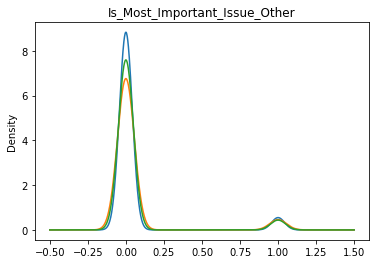

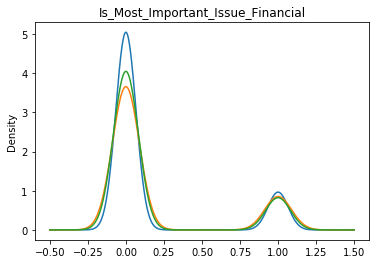

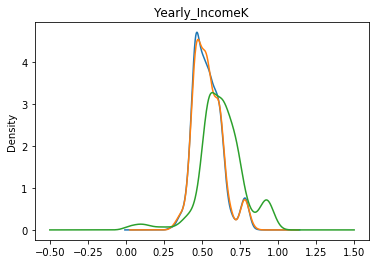

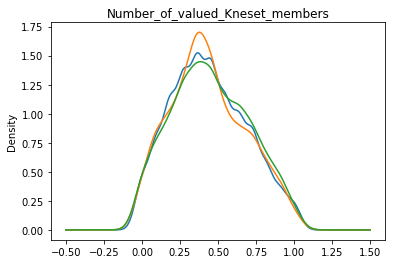

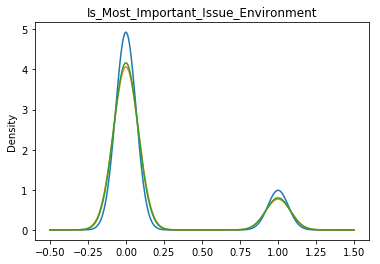

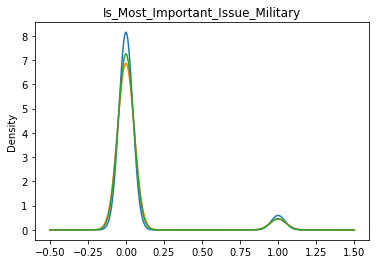

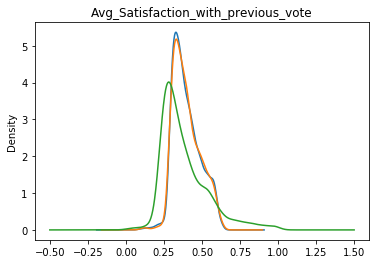

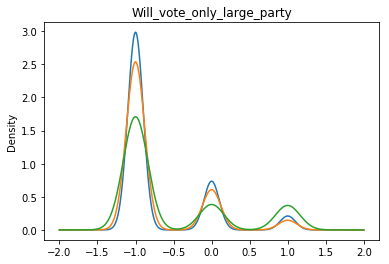

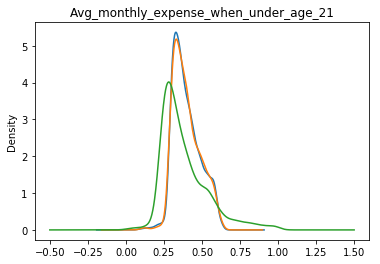

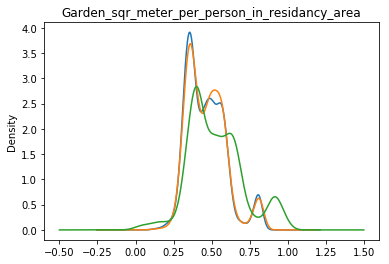

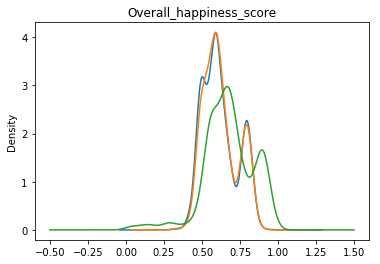

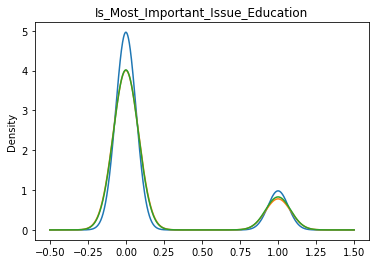

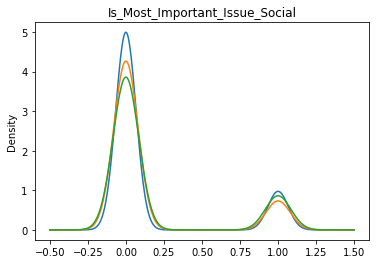

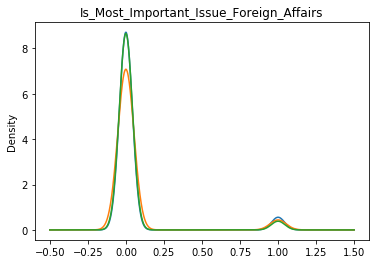

In [79]:
for f in df_train_X.columns:
    df_train_X[f].plot(kind='kde')
    df_test_X[f].plot(kind='kde')
    df_validation_clean[f].plot(kind='kde')
    plt.title(f)
    plt.show()

In [75]:
clf = RandomForestClassifier(min_samples_split=4, random_state=0)
clf.fit(features, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [77]:
pred = clf.predict(df_test_X)
distribution = Counter(pred)
print distribution
print "predicted winner is party ## %s ##" % distribution.most_common(1)[0][0]
print labels[6]


pred = clf.predict(df_validation_clean)
distribution = Counter(pred)
print distribution
print "predicted winner is party ## %s ##" % distribution.most_common(1)[0][0]
print labels[6]
# distribution = np.bincount(pred.astype('int64'))
# most_common = np.argmax(distribution)

# print "winner is party ## %s ##" % labels[most_common.astype('int')]

Counter({'Purples': 410, 'Browns': 399, 'Greens': 315, 'Pinks': 144, 'Reds': 118, 'Greys': 102, 'Oranges': 95, 'Yellows': 73, 'Whites': 47, 'Blues': 3})
predicted winner is party ## Purples ##
Purples
Counter({'Yellows': 1651, 'Oranges': 154, 'Greens': 117, 'Purples': 47, 'Pinks': 16, 'Greys': 10, 'Blues': 5})
predicted winner is party ## Yellows ##
Purples
